In [1]:
import sys
import pandas as pd
import numpy as np

sys.path.append('.')
data_daily = pd.read_csv('./data/48_Industry_Portfolios_Daily.csv', index_col=0)

# Trim the data
data_daily = data_daily.iloc[('197401' <= data_daily.index.values.astype(str)) & (data_daily.index.values.astype(str) <= '202012')]

# Convert the index to datetime
data_daily.index = pd.to_datetime(data_daily.index, format='%Y%m%d')
daily_date = data_daily.index.date

# The rate of return matrix, fill the missing values with 100%
Return = data_daily.values.T.astype(float)
Return[Return < -99]
Gross_return = (Return + 100) / 100 # Gross Return

print(Gross_return.shape)

# Check the first few rows of the dataset
data_daily.head()

window_size = 120

(48, 11834)


In [2]:
from algorithms.ucb import UCB
ucb = UCB(Gross_return, window_size)
ucb.run()

In [3]:
from algorithms.psr import PSR
psr = PSR(Gross_return, window_size)
psr.run()

In [4]:
from algorithms.ucb_psr import UCBPSR
ucb_psr = UCBPSR(Gross_return, window_size)
ucb_psr.run()

In [5]:
# Baseline
constant_weight_rebalance = np.cumprod(Gross_return[:, window_size:].mean(axis=0))
equal_weight_portfolio = np.mean(np.cumprod(Gross_return[:, window_size:], axis=1), axis=0)
ew_reward = np.mean(Gross_return[:, window_size:], axis=0)

In [6]:
# Save the results
all_returns = {"EW": ew_reward, 
               "UCB1": ucb.reward,
               "PSR": psr.reward,
               "UCBPSR": ucb_psr.reward
        }
z = pd.DataFrame(all_returns) - 1
z = z.to_csv('./output/new_reward.csv')


In [7]:
# Cumulative wealth
cumulative_wealths = {
    "CWR": constant_weight_rebalance,
    "EW": equal_weight_portfolio,
    "UCB1": ucb.get_cumulative_wealth(),
    "PSR": psr.get_cumulative_wealth(),
    "UCBPSR": ucb_psr.get_cumulative_wealth()
}
results = pd.DataFrame(cumulative_wealths)
results_pct = results.pct_change().dropna()
results_pct
results_pct.std() * 100 * np.sqrt(252)  # Annualized volatility

CWR       16.861927
EW        16.437077
UCB1      19.012254
PSR       22.757221
UCBPSR    19.893144
dtype: float64

In [ ]:
date = data_daily.index.values[window_size:]
results.index = date
results_pct.index = date[1:]
years = pd.date_range(start="1974", end="2019", freq='YE').year
years = [str(year) for year in years]

yearly_sharpes = {}
for col in results_pct.columns:
    col_ = {}
    for a in range(1, len(years)):
        col_[years[a]] = np.sqrt(252) * np.mean(results_pct.loc[years[a-1]:years[a], col]) / np.std(results_pct.loc[years[a-1]:years[a], col])
    yearly_sharpes[col] = []

yearly_sharpes = pd.DataFrame(yearly_sharpes)
results_pct.to_csv('./output/pct_changes.csv')

/var/folders/6s/spnsxhq51jbb9vtvsmp70n440000gp/T/ipykernel_87790/2466677043.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  years = pd.date_range(start="1974", end="2019", freq='Y').year


In [9]:
yearly_sharpes.mean().sort_values(ascending=False)

((np.mean(results_pct)/np.std(results_pct))*np.sqrt(252)).sort_values(ascending=False)

results.loc["1984":"1994", :]
results.to_csv('./output/results.csv')

/Users/frank/Projects/qf-research/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


/var/folders/6s/spnsxhq51jbb9vtvsmp70n440000gp/T/ipykernel_87790/1574948785.py:26: UserWarning: The dashes list has more values (8) than needed (5), which may not be intended.
  ax = sns.lineplot(data=wealth_74_84, palette="bright", linewidth=2.7, dashes=dash_styles)
/var/folders/6s/spnsxhq51jbb9vtvsmp70n440000gp/T/ipykernel_87790/1574948785.py:30: UserWarning: The dashes list has more values (8) than needed (5), which may not be intended.
  ax = sns.lineplot(data=wealth_84_94, palette="bright", linewidth=2.7, dashes=dash_styles)
/var/folders/6s/spnsxhq51jbb9vtvsmp70n440000gp/T/ipykernel_87790/1574948785.py:34: UserWarning: The dashes list has more values (8) than needed (5), which may not be intended.
  ax = sns.lineplot(data=wealth_94_04, palette="bright", linewidth=2.7, dashes=dash_styles)
/var/folders/6s/spnsxhq51jbb9vtvsmp70n440000gp/T/ipykernel_87790/1574948785.py:38: UserWarning: The dashes list has more values (8) than needed (5), which may not be intended.
  ax = sns.lineplot(

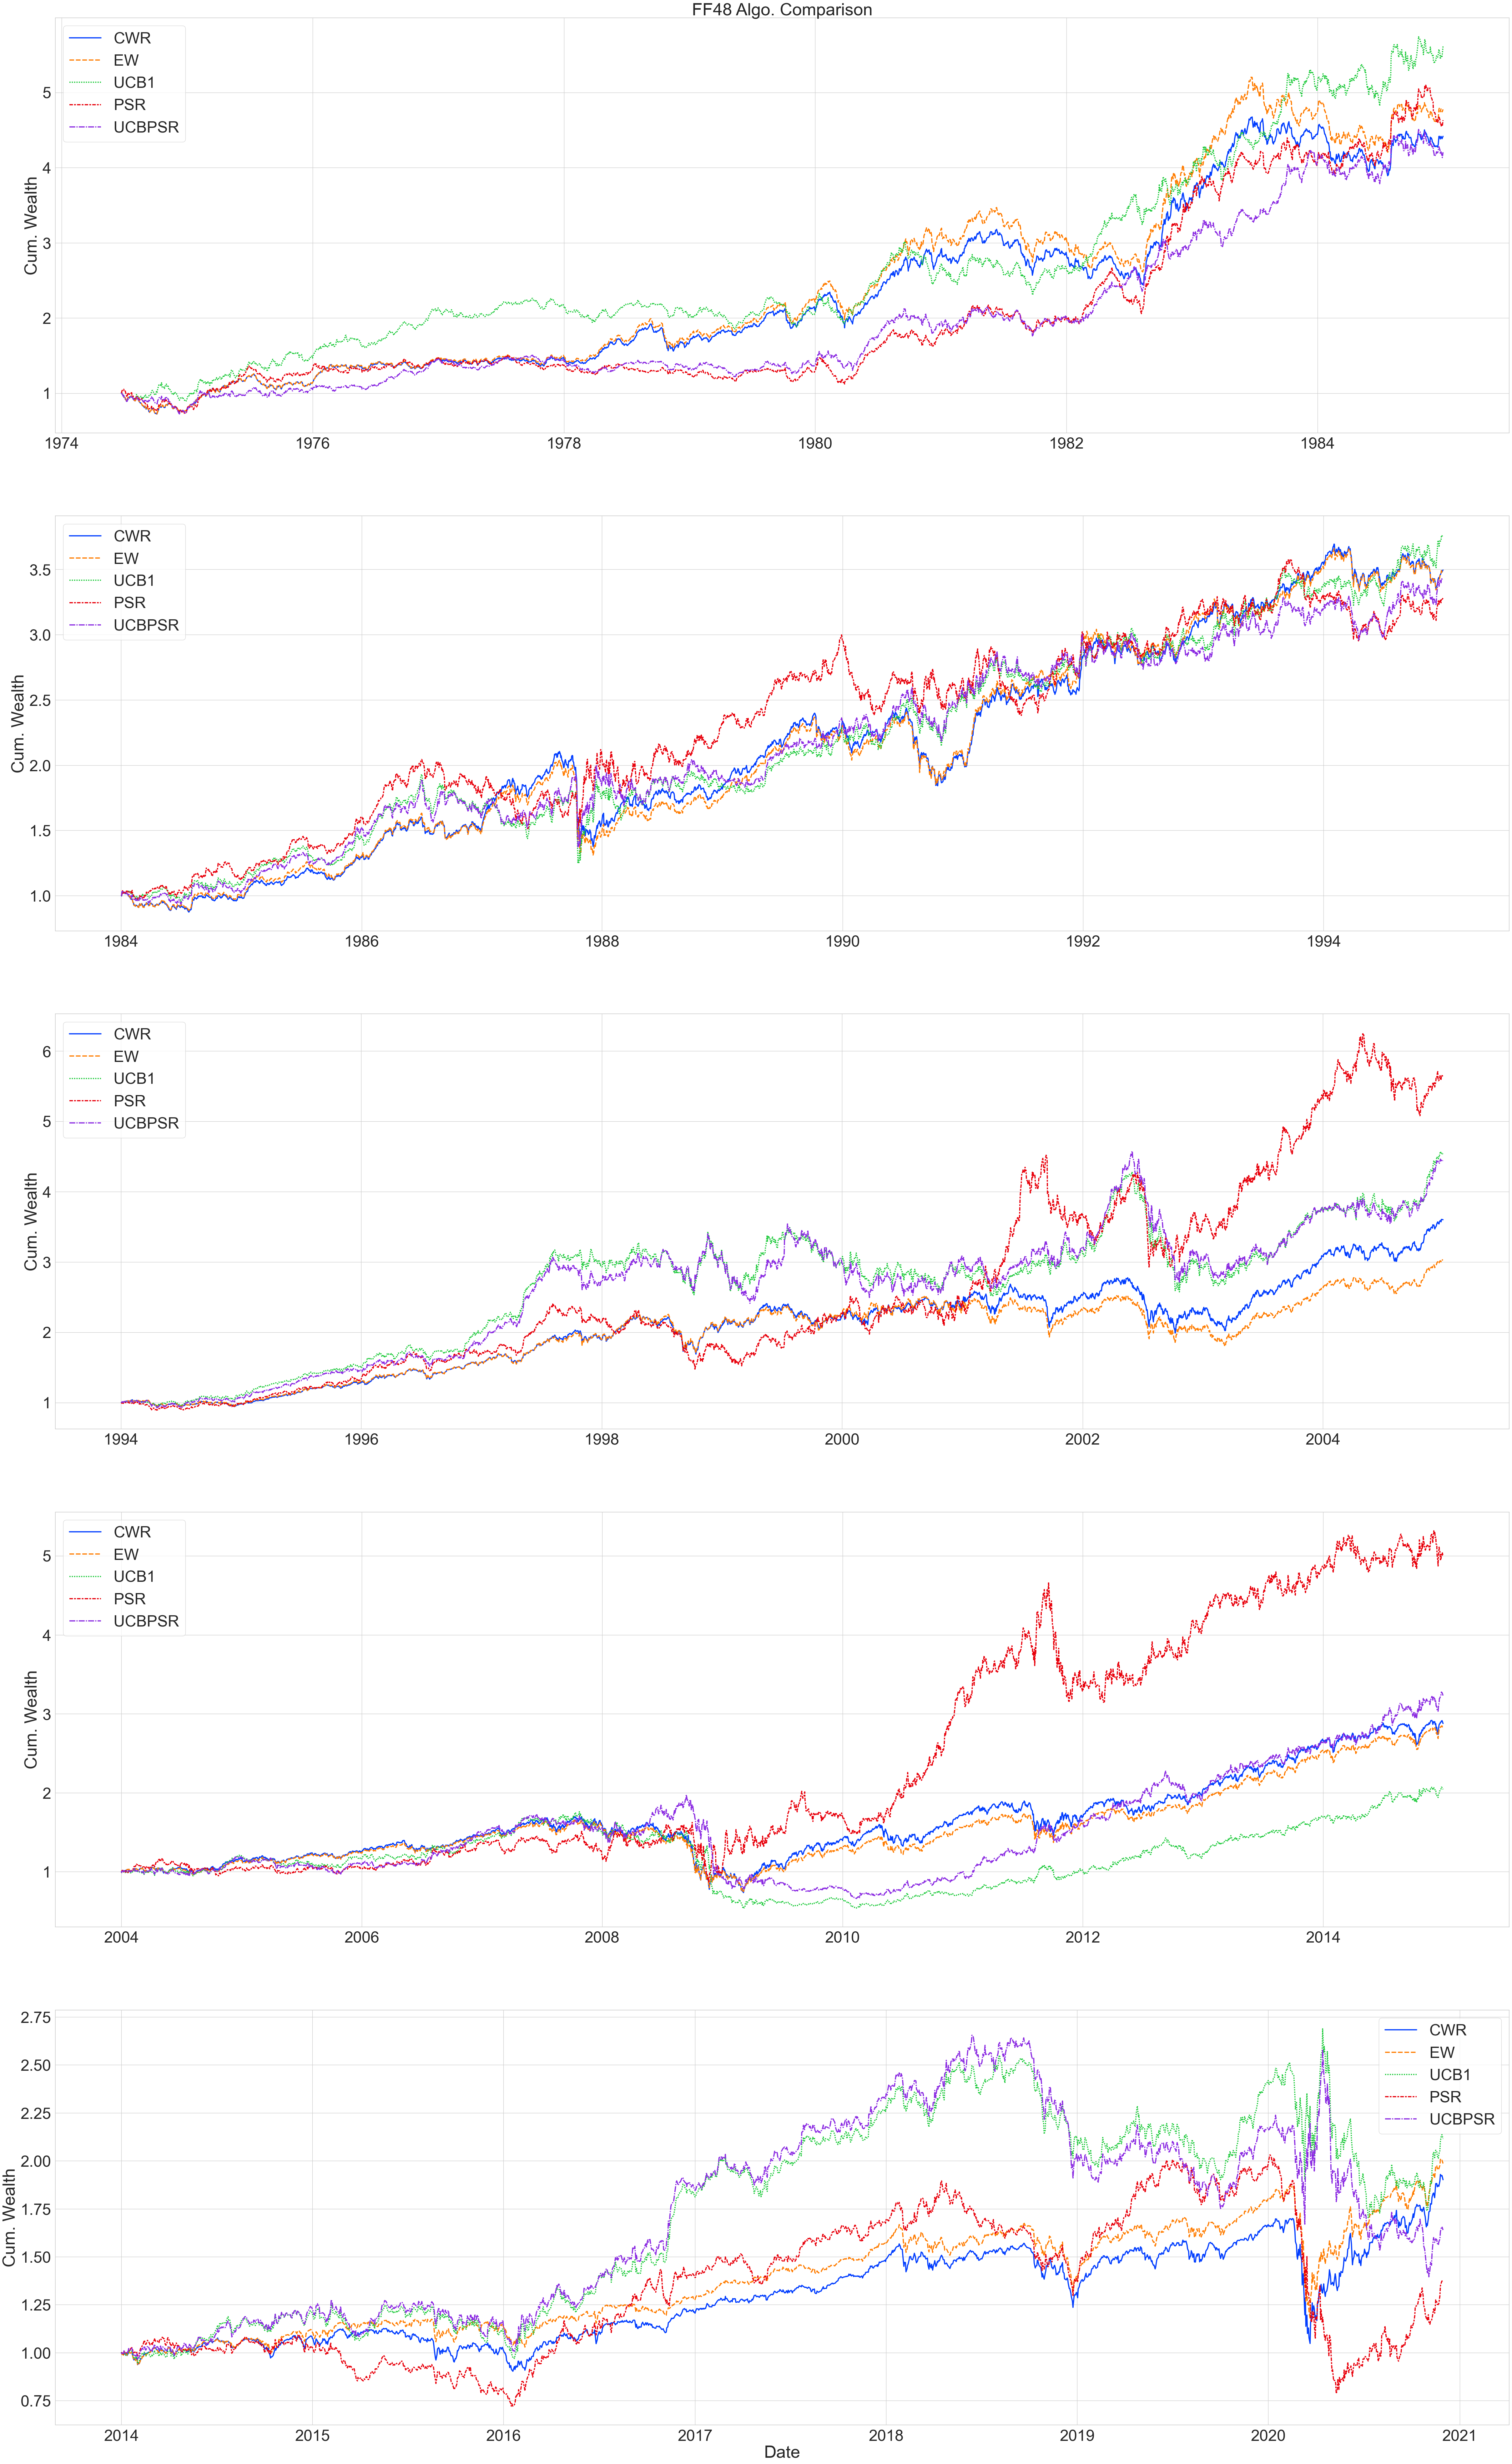

In [10]:
# Graphs
array_size = 5

wealth_74_84 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(array_size).reshape(-1, array_size), results_pct.loc["1974":"1984", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["1974":"1984", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["1974":"1984", :].index[-1], periods=results_pct.loc["1974":"1984", :].shape[0]+1).date))
wealth_84_94 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(array_size).reshape(-1, array_size), results_pct.loc["1984":"1994", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["1984":"1994", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["1984":"1994", :].index[-1], periods=results_pct.loc["1984":"1994", :].shape[0]+1).date))
wealth_94_04 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(array_size).reshape(-1, array_size), results_pct.loc["1994":"2004", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["1994":"2004", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["1994":"2004", :].index[-1], periods=results_pct.loc["1994":"2004", :].shape[0]+1).date))
wealth_04_14 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(array_size).reshape(-1, array_size), results_pct.loc["2004":"2014", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["2004":"2014", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["2004":"2014", :].index[-1], periods=results_pct.loc["2004":"2014", :].shape[0]+1).date))
wealth_14_20 = np.cumprod(pd.DataFrame(np.concatenate((np.ones(array_size).reshape(-1, array_size), results_pct.loc["2014":"2020", :].values+1), axis=0), columns=results_pct.columns, index=pd.date_range(start=results_pct.loc["2014":"2020", :].index[0]-pd.Timedelta("1d"), end=results_pct.loc["2014":"2020", :].index[-1], periods=results_pct.loc["2014":"2020", :].shape[0]+1).date))

import seaborn as sns
import matplotlib.pyplot as plt

dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

sns.set(style="whitegrid", font_scale=3.3)
plt.figure(figsize=(60, 100))

plt.subplot(5,1,1)
ax = sns.lineplot(data=wealth_74_84, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth', title="FF48 Algo. Comparison")

plt.subplot(5,1,2)
ax = sns.lineplot(data=wealth_84_94, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth')

plt.subplot(5,1,3)
ax = sns.lineplot(data=wealth_94_04, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth')

plt.subplot(5,1,4)
ax = sns.lineplot(data=wealth_04_14, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(ylabel='Cum. Wealth')

plt.subplot(5,1,5)
ax = sns.lineplot(data=wealth_14_20, palette="bright", linewidth=2.7, dashes=dash_styles)
ax.set(xlabel="Date", ylabel='Cum. Wealth')
ax.figure.savefig("output_2.png")
